# IoU / Dice coefficient

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.losses as losses
from glob import glob
#segmentation loss는 이미지분류처럼 케라스나 텐서플로우에서 공식적으로 제공하는 loss가 없기때문에 직접 구현해야함 

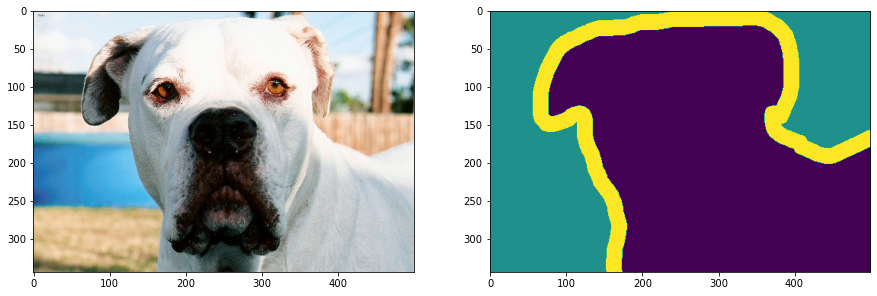

In [7]:
#trimaps/ Trimap annotations for every image in the dataset
#    Pixel Annotations: 1: Foreground 2:Background 3: Not classified

image_files = glob('data/images/*.jpg')
image_path = image_files[333] #임의의 파일
seg_path = image_path.replace('images', 'annotations/trimaps')#segmentation file의 경로
seg_path = seg_path.replace('jpg', 'png')

image = cv2.imread(image_path)#이미지 읽기
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#BGR이미지를 RGB파일로 바꿔주기
seg_map = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)

#시각화
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(seg_map)
plt.show()

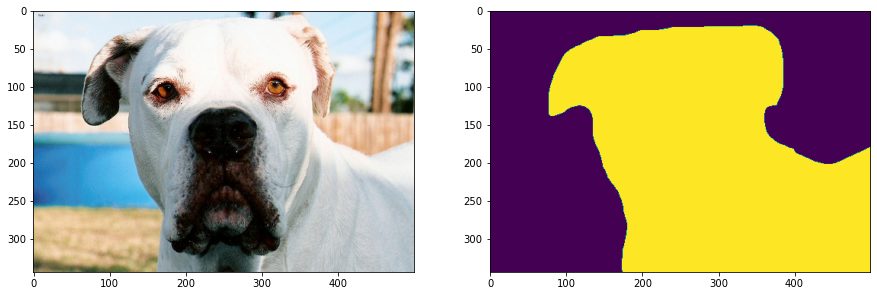

In [8]:
seg_map[seg_map != 1] = 0 #segmap에서 1이 아니면 모두 0으로 바꿔주기(개가 아니면 모두 0)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(seg_map)
plt.show()
#라벨이 꽤 정교하게 

# IoU/Jaccard Index
![alt text](iou.png "Title")


# Dice coefficient
![alt text](dice.png "Title")

In [9]:

'''
두 마스크가 주어져 있을때 겹치는 부분을 구하려면 각 픽셀에 대해서 모델이 제대로 예측을 했는지 맞다 틀리다를 알아야함
맞다 틀리다라는 함수는 특정 threshold를 기준으로 틀리면 0 맞으면1이라는 step function을 가지는데
이는 미분가능하지 않기때문에 이 개념을 바로 모델에 사용할 수 없다.
이를 연속적인 함수로 만들기 위해서 라벨의 0과 1을 각 픽셀이 특정 클래스에 속할 확률값으로 해석가능
기존의 binary classification에서 사용했던 것 처럼 각 픽셀의 라벨과 모든 출력값을 곱해주면 모델이 각 픽셀을 얼마나 잘 분류했는지 알 수 있음
기존의 맞다 틀리다라는 개념에 일부분만 맞췄다는게 추가돼서
continuous한 함수가 되기 때문에 미분이 가능해져서 학습에 IoU와 dice를 사용할 수 있게 됨
'''
def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten : 인풋은 2차원이지만 편리하게 계산하기 위해 faltten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    '''
    y_true = | 0 | 1 | 1 | 0 | -> 4차원의 벡터
    y_pred = | 0.5 | 1 | 0.2 | 0.3 | ->4차원의 벡터
    각각은 특정 클래스에 속하는 확률값
    y_true * y_pred = | 0 | 1 | 0.2 | 0 | -> 1.2(두 개의 겹치는 값)
    '''
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    #sum으로 픽셀 개수를 구할 수 있는 것은 input값이 0-1사이의 값으로 이루어져있기 때문
    score = intersection / (union + smooth)
    return score


def dice_coef(y_true, y_pred): #성능이 좋을 수록 1에 가까운 값
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score


def dice_loss(y_true, y_pred):#성능이 안좋을수록 1에 가까운 값
    loss = 1 - dice_coef(y_true, y_pred)

    return loss


def bce_dice_loss(y_true, y_pred):#segmentation을 할 때 dice loss와 함께 binary_crossentropy도 같이 사용함
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [10]:
print(dice_coef(seg_map.astype('float32'), seg_map.astype('float32')).numpy())
print(iou(seg_map.astype('float32'), seg_map.astype('float32')).numpy())

1.0
1.0


In [11]:
zeros = np.zeros_like(seg_map) #intersection이 모두 0일것
print(dice_coef(seg_map.astype('float32'), zeros.astype('float32')).numpy())
print(iou(seg_map.astype('float32'), zeros.astype('float32')).numpy())

0.0
0.0


In [12]:
ones = np.ones_like(seg_map)
print(dice_coef(seg_map.astype('float32'), ones.astype('float32')).numpy())
print(iou(seg_map.astype('float32'), ones.astype('float32')).numpy())

0.7120467
0.5528513
